In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('bankex.csv', index_col=['date'])
prices.head(10)

HDFCBANK.NS  ICICIBANK.NS  KOTAKBANK.NS  AXISBANK.NS     SBIN.NS  \
date                                                                           
01-01-2018   927.250000    310.299988    999.950012   565.500000  307.100006   
02-01-2018   936.174988    309.700012   1003.200012   559.500000  303.250000   
03-01-2018   926.325012    315.000000   1000.099976   560.450012  302.850006   
04-01-2018   929.950012    314.700012   1000.400024   559.900024  308.500000   
05-01-2018   931.799988    312.899994   1003.049988   563.250000  306.350006   
08-01-2018   930.299988    314.149994   1006.099976   565.450012  305.799988   
09-01-2018   931.849976    312.600006   1009.750000   565.299988  304.299988   
10-01-2018   932.099976    312.000000   1002.250000   562.799988  301.100006   
11-01-2018   936.275024    309.500000   1017.650024   558.750000  302.200012   
12-01-2018   932.650024    317.700012   1023.349976   555.099976  302.250000   

            INDUSINDBK.NS  FEDERALBNK.NS  IDFCFIRSTB.NS   AUBANK.NS  
date                                                                 
01-01-2018    1623.849976     108.699997      54.849998  662.849976  
02-01-2018    1643.949951     107.599998      53.950001  661.400024  
03-01-2018    1630.250000     107.699997      54.150002  669.750000  
04-01-2018    1646.599976     108.650002      54.549999  675.000000  
05-01-2018    1698.199951     112.099998      58.250000  699.450012  
08-01-2018    1719.900024     115.550003      63.349998  712.000000  
09-01-2018    1725.050049     115.150002      62.799999  699.400024  
10-01-2018    1734.099976     113.150002      63.250000  699.549988  
11-01-2018    1700.300049     114.000000      68.550003  709.549988  
12-01-2018    1705.250000     115.050003      67.500000  705.200012

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

HDFCBANK.NS  ICICIBANK.NS  KOTAKBANK.NS  AXISBANK.NS     SBIN.NS  \
date                                                                           
01-01-2018   927.250000    310.299988    999.950012   565.500000  307.100006   
02-01-2018   936.174988    309.700012   1003.200012   559.500000  303.250000   
30-12-2020  1432.500000    528.750000   2017.949951   625.099976  276.899994   
31-12-2020  1436.300049    535.049988   1995.599976   620.450012  274.950012   

            INDUSINDBK.NS  FEDERALBNK.NS  IDFCFIRSTB.NS   AUBANK.NS  
date                                                                 
01-01-2018    1623.849976     108.699997      54.849998  662.849976  
02-01-2018    1643.949951     107.599998      53.950001  661.400024  
30-12-2020     899.049988      67.250000      36.650002  852.450012  
31-12-2020     894.950012      66.699997      37.049999  852.599976

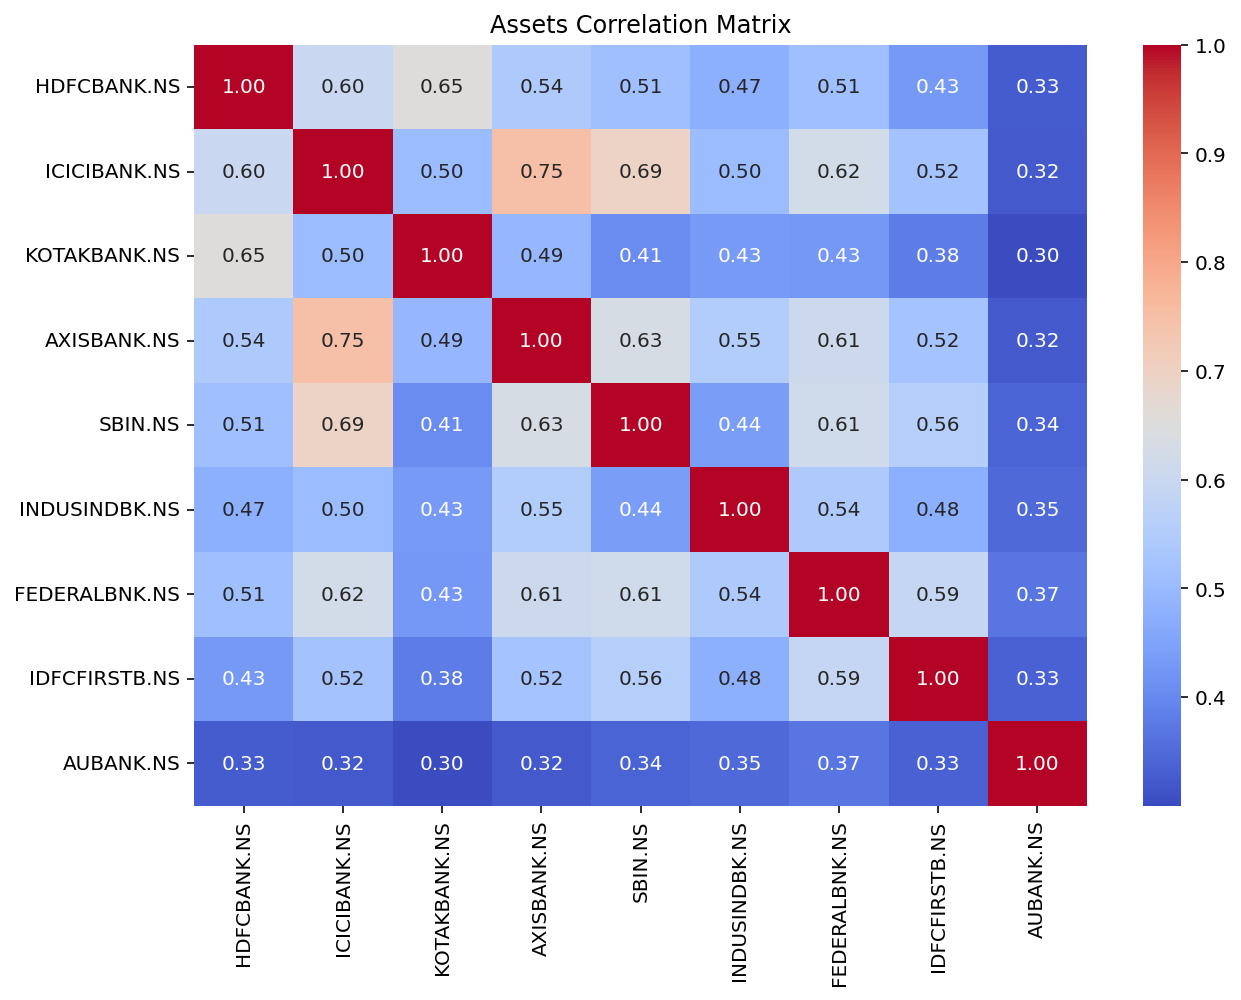

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('HDFCBANK.NS', 'KOTAKBANK.NS'), ('AXISBANK.NS', 'SBIN.NS'), ('FEDERALBNK.NS', 'IDFCFIRSTB.NS')]


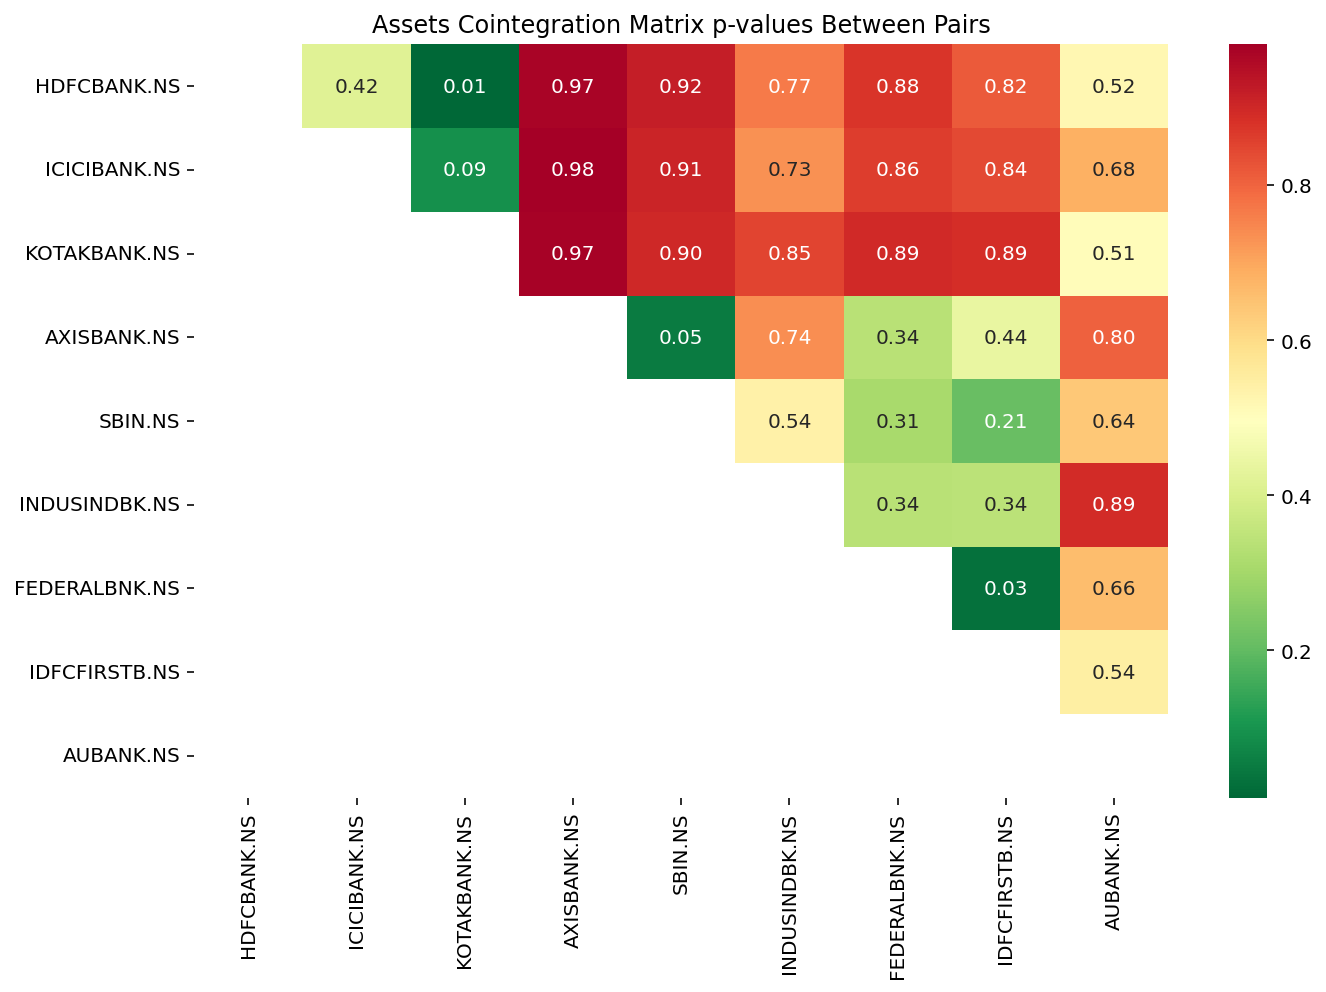

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'HDFCBANK.NS'
asset2 = 'KOTAKBANK.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

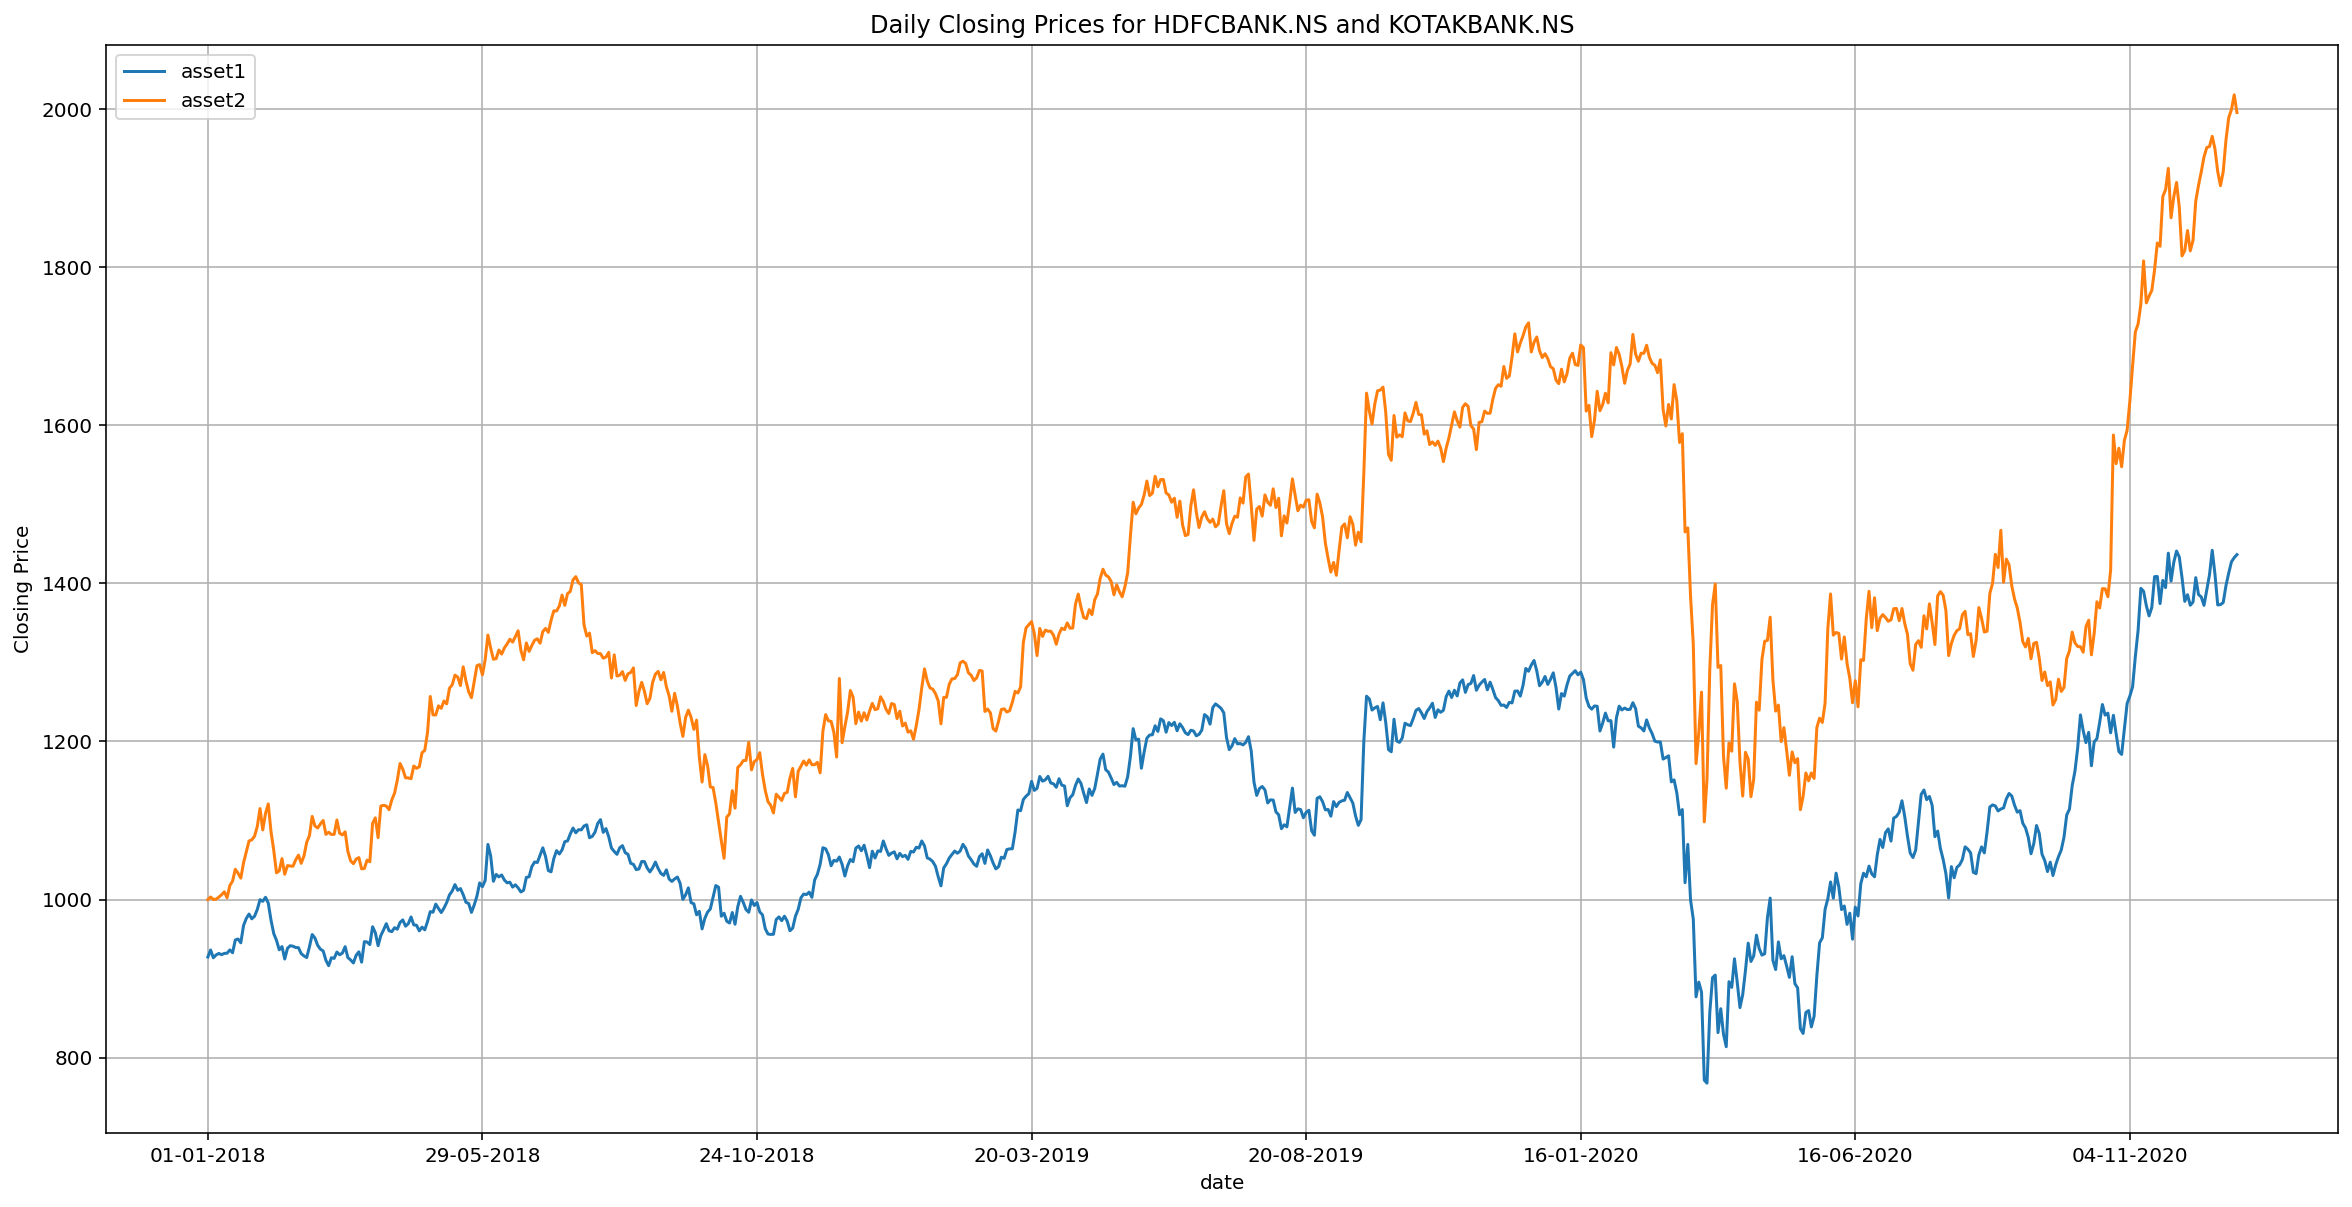

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.759e+05
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        08:27:45   Log-Likelihood:                         -4379.0
No. Observations:                 740   AIC:                                      8760.
Df Residuals:                     739   BIC:                                      8765.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         1.2553      0.003    419.434      0.000       1.249       1.261
==============================================================================
Omnibus:                       17.196   Durbin-Watson:                   0.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.274
Skew:                           0.264   Prob(JB):                     0.000795
Kurtosis:                       2.571   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  1.255316936342714


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

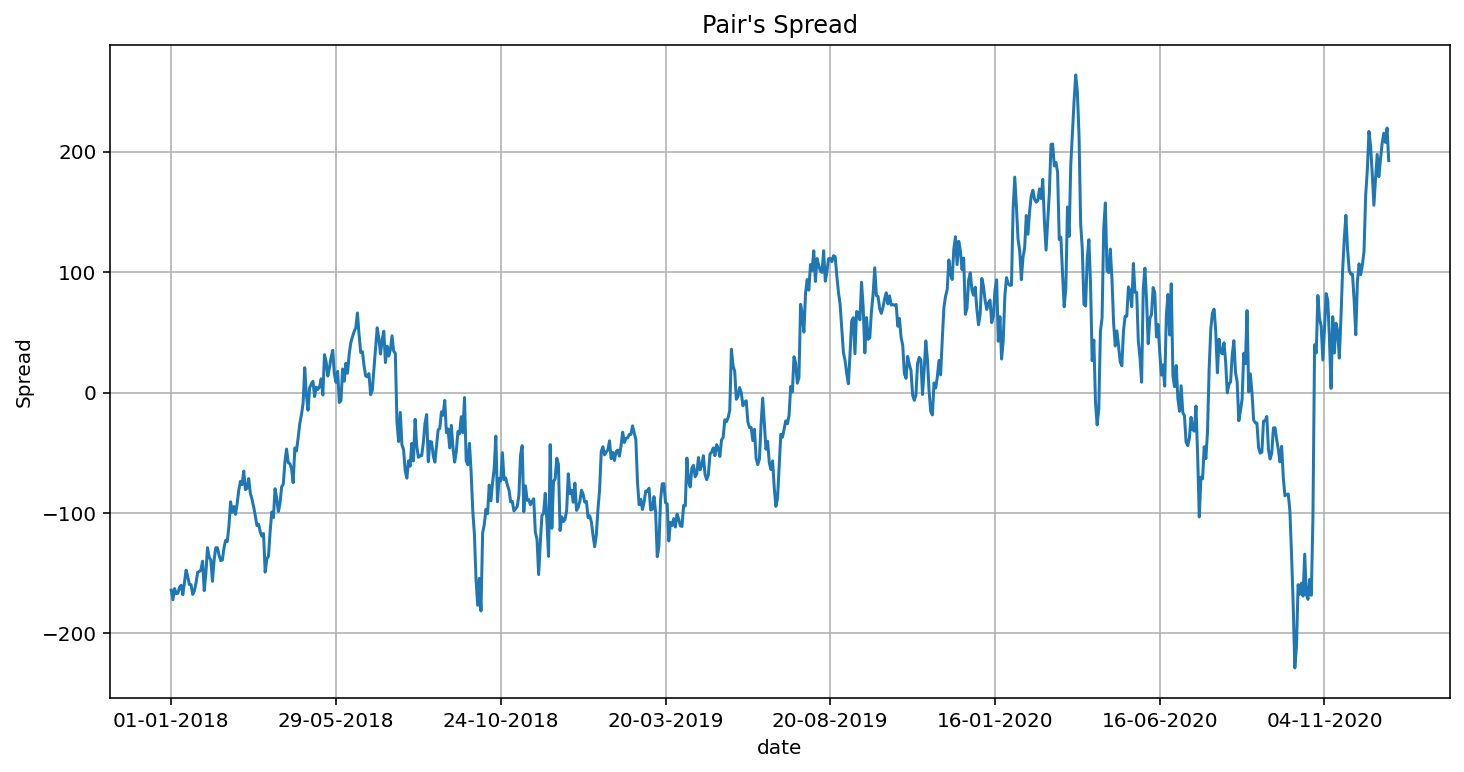

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.190683604083595,
 0.020530321872948388,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 6632.373097332204)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -3.190683604083595


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1       asset2
date                                
01-01-2021  1425.050049  1994.050049
04-01-2021  1416.000000  1965.550049
05-01-2021  1426.699951  1959.750000
06-01-2021  1420.550049  1970.400024
07-01-2021  1416.250000  1952.400024

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1       asset2         z  z upper limit  z lower limit
date                                                                        
01-01-2021  1425.050049  1994.050049 -2.613729            1.0           -1.0
04-01-2021  1416.000000  1965.550049 -2.467995            1.0           -1.0
05-01-2021  1426.699951  1959.750000 -2.275842            1.0           -1.0
06-01-2021  1420.550049  1970.400024 -2.454430            1.0           -1.0
07-01-2021  1416.250000  1952.400024 -2.341945            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

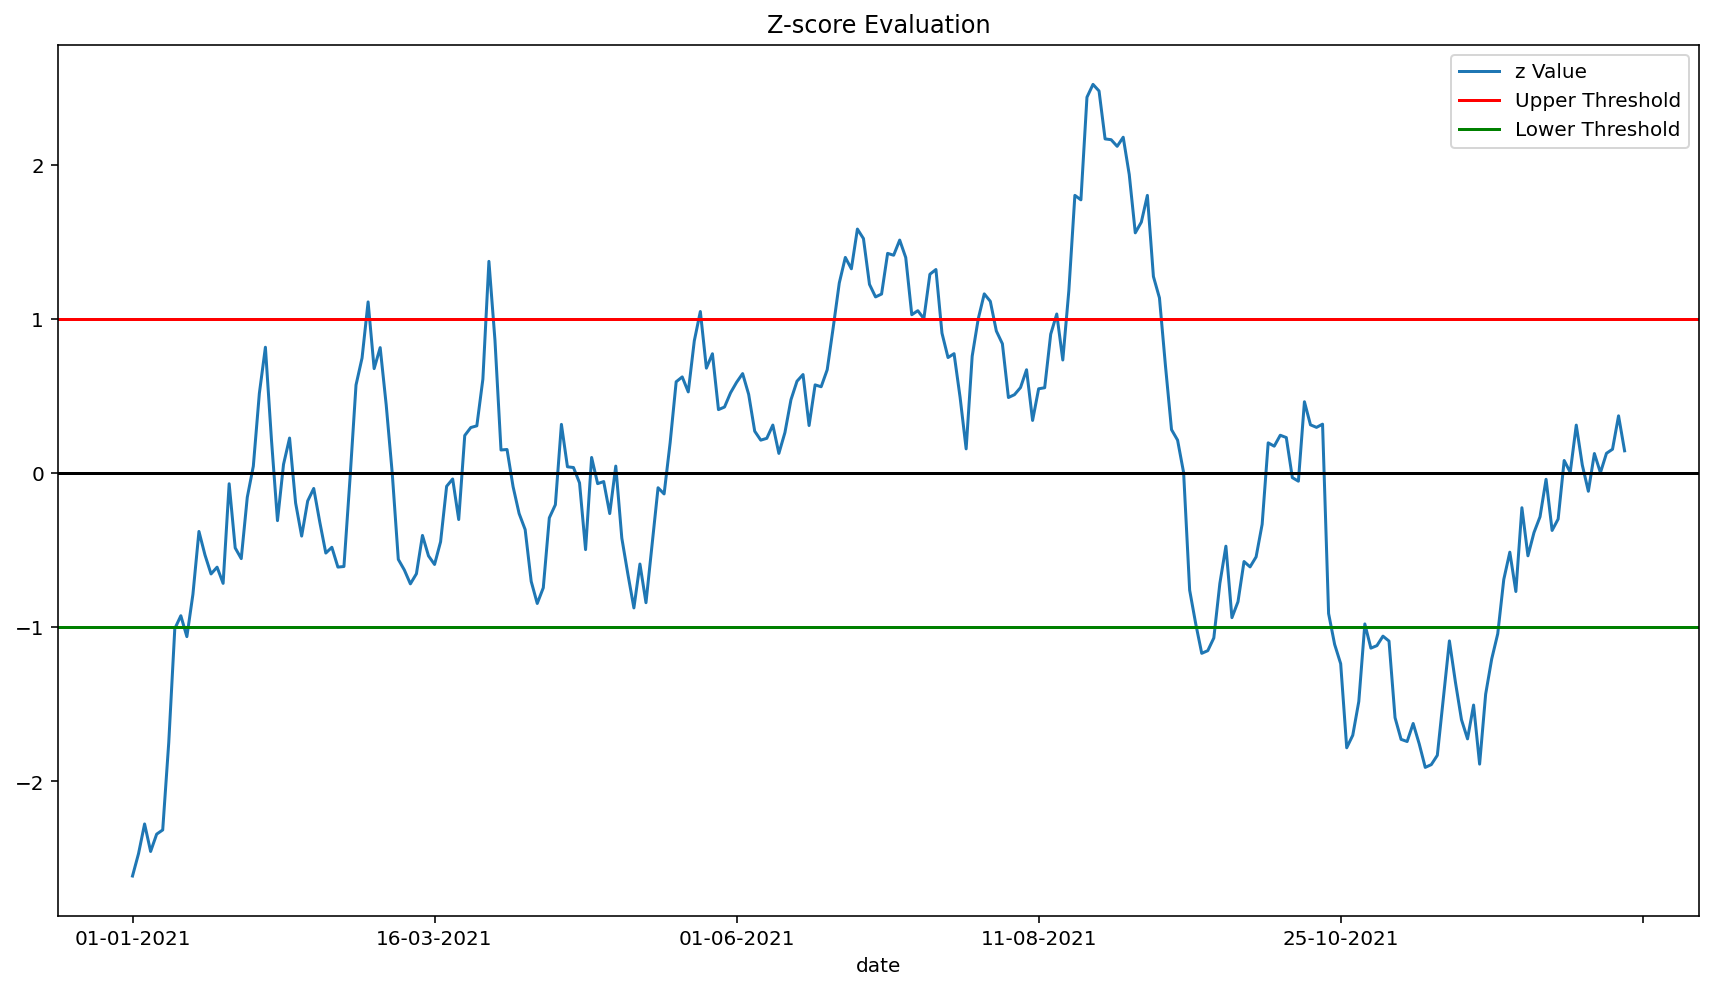

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  1425.050049  1994.050049 -2.613729            1.0           -1.0   
04-01-2021  1416.000000  1965.550049 -2.467995            1.0           -1.0   
05-01-2021  1426.699951  1959.750000 -2.275842            1.0           -1.0   
29-12-2021  1453.849976  1764.199951  0.156042            1.0           -1.0   
30-12-2021  1461.500000  1755.250000  0.372706            1.0           -1.0   
31-12-2021  1479.400024  1796.099976  0.145639            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  1425.050049  1994.050049 -2.613729            1.0           -1.0   
04-01-2021  1416.000000  1965.550049 -2.467995            1.0           -1.0   
05-01-2021  1426.699951  1959.750000 -2.275842            1.0           -1.0   
06-01-2021  1420.550049  1970.400024 -2.454430            1.0           -1.0   
07-01-2021  1416.250000  1952.400024 -2.341945            1.0           -1.0   
08-01-2021  1431.650024  1970.699951 -2.314648            1.0           -1.0   
11-01-2021  1451.449951  1938.150024 -1.747286            1.0           -1.0   
12-01-2021  1481.000000  1903.449951 -1.008821            1.0           -1.0   
14-01-2021  1468.750000  1892.650024 -1.060266            1.0           -1.0   
26-02-2021  1534.400024  1780.349976  1.111966            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
08-01-2021         1         0.0        -1         0.0  
11-01-2021         1         0.0        -1         0.0  
12-01-2021         1         0.0        -1         0.0  
14-01-2021         1         1.0        -1        -1.0  
26-02-2021        -1        -1.0         1         1.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  1425.050049  1994.050049 -2.613729            1.0           -1.0   
13-01-2021  1470.650024  1882.099976 -0.924616            1.0           -1.0   
14-01-2021  1468.750000  1892.650024 -1.060266            1.0           -1.0   
15-01-2021  1466.650024  1863.900024 -0.785821            1.0           -1.0   
26-02-2021  1534.400024  1780.349976  1.111966            1.0           -1.0   
24-09-2021  1601.550049  2028.099976 -0.714740            1.0           -1.0   
22-10-2021  1680.750000  2171.399902 -1.110595            1.0           -1.0   
29-10-2021  1582.849976  2031.150024 -0.977774            1.0           -1.0   
01-11-2021  1605.300049  2076.500000 -1.134895            1.0           -1.0   
03-12-2021  1513.550049  1914.199951 -0.689028            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
13-01-2021         0        -1.0         0         1.0  
14-01-2021         1         1.0        -1        -1.0  
15-01-2021         0        -1.0         0         1.0  
26-02-2021        -1        -1.0         1         1.0  
24-09-2021         0        -1.0         0         1.0  
22-10-2021         1         1.0        -1        -1.0  
29-10-2021         0        -1.0         0         1.0  
01-11-2021         1         1.0        -1        -1.0  
03-12-2021         0        -1.0         0         1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

1468.750000    1
1558.900024    1
1493.650024    1
1478.949951    1
1471.000000    1
1422.650024    1
1514.650024    1
1555.550049    1
1551.949951    1
1680.750000    1
1605.300049    1
Name: asset1, dtype: int64

In [32]:
signals

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  1425.050049  1994.050049 -2.613729            1.0           -1.0   
04-01-2021  1416.000000  1965.550049 -2.467995            1.0           -1.0   
05-01-2021  1426.699951  1959.750000 -2.275842            1.0           -1.0   
06-01-2021  1420.550049  1970.400024 -2.454430            1.0           -1.0   
07-01-2021  1416.250000  1952.400024 -2.341945            1.0           -1.0   
...                 ...          ...       ...            ...            ...   
27-12-2021  1450.800049  1773.449951  0.003725            1.0           -1.0   
28-12-2021  1460.800049  1774.900024  0.129409            1.0           -1.0   
29-12-2021  1453.849976  1764.199951  0.156042            1.0           -1.0   
30-12-2021  1461.500000  1755.250000  0.372706            1.0           -1.0   
31-12-2021  1479.400024  1796.099976  0.145639            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

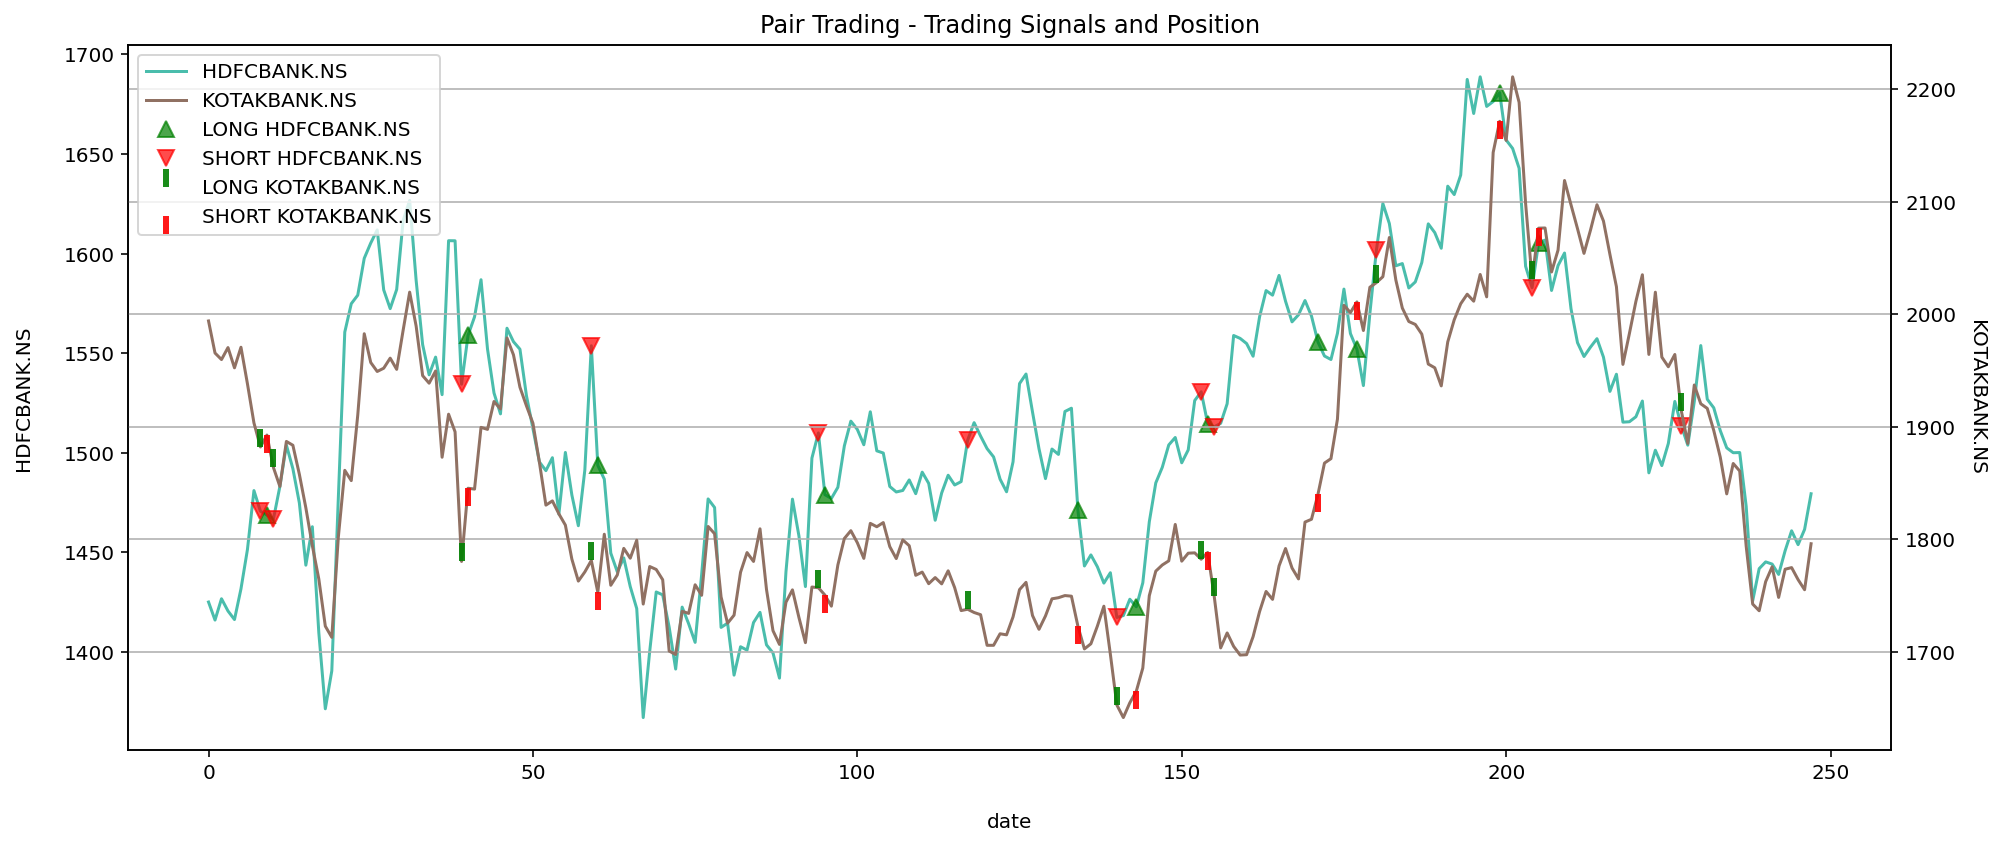

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    1425.050049           NaN            NaN            NaN       NaN   
1    1416.000000      0.000000  100000.000000  100000.000000       NaN   
2    1426.699951      0.000000  100000.000000  100000.000000  0.000000   
3    1420.550049      0.000000  100000.000000  100000.000000  0.000000   
4    1416.250000      0.000000  100000.000000  100000.000000  0.000000   
243  1450.800049 -85597.202891  182502.648643   96905.445752 -0.007193   
244  1460.800049 -86187.202891  182502.648643   96315.445752 -0.006088   
245  1453.849976 -85777.148584  182502.648643   96725.500059  0.004257   
246  1461.500000 -86228.500000  182502.648643   96274.148643 -0.004666   
247  1479.400024 -87284.601416  182502.648643   95218.047227 -0.010970   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1      holdings1          cash1   total asset1       return1  \
0   1425.050049            NaN            NaN            NaN           NaN   
8   1470.650024  -86768.351416  186768.351416  100000.000000 -1.110223e-16   
9   1468.750000       0.000000  100112.101416  100112.101416  1.121014e-03   
10  1466.650024  -86532.351416  186644.452832  100112.101416  0.000000e+00   
39  1534.400024 -181059.202832  277174.054248   96114.851416  4.624084e-02   

    positions1  
0          NaN  
8         -1.0  
9          1.0  
10        -1.0  
39        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    1425.050049           NaN            NaN            NaN       NaN   
1    1416.000000      0.000000  100000.000000  100000.000000       NaN   
2    1426.699951      0.000000  100000.000000  100000.000000  0.000000   
3    1420.550049      0.000000  100000.000000  100000.000000  0.000000   
4    1416.250000      0.000000  100000.000000  100000.000000  0.000000   
243  1450.800049 -85597.202891  182502.648643   96905.445752 -0.007193   
244  1460.800049 -86187.202891  182502.648643   96315.445752 -0.006088   
245  1453.849976 -85777.148584  182502.648643   96725.500059  0.004257   
246  1461.500000 -86228.500000  182502.648643   96274.148643 -0.004666   
247  1479.400024 -87284.601416  182502.648643   95218.047227 -0.010970   

     positions1       asset2     holdings2          cash2   total asset2  \
0           NaN  1994.050049           NaN            NaN            NaN   
1           0.0  1965.550049      0.000000  100000.000000  100000.000000   
2           0.0  1959.750000      0.000000  100000.000000  100000.000000   
3           0.0  1970.400024      0.000000  100000.000000  100000.000000   
4           0.0  1952.400024      0.000000  100000.000000  100000.000000   
243         0.0  1773.449951  79805.247795   35013.254365  114818.502160   
244         0.0  1774.900024  79870.501080   35013.254365  114883.755445   
245         0.0  1764.199951  79388.997795   35013.254365  114402.252160   
246         0.0  1755.250000  78986.250000   35013.254365  113999.504365   
247         0.0  1796.099976  80824.498920   35013.254365  115837.753285   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.009915         0.0  
244  0.000568         0.0  
245 -0.004191         0.0  
246 -0.003520         0.0  
247  0.016125         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1      holdings1          cash1   total asset1       return1  \
0   1425.050049            NaN            NaN            NaN           NaN   
8   1470.650024  -86768.351416  186768.351416  100000.000000 -1.110223e-16   
9   1468.750000       0.000000  100112.101416  100112.101416  1.121014e-03   
10  1466.650024  -86532.351416  186644.452832  100112.101416  0.000000e+00   
39  1534.400024 -181059.202832  277174.054248   96114.851416  4.624084e-02   

    positions1       asset2     holdings2         cash2  total asset2  \
0          NaN  1994.050049           NaN           NaN           NaN   
8         -1.0  1882.099976   84694.49892   15305.50108  100000.00000   
9          1.0  1892.650024       0.00000  100474.75216  100474.75216   
10        -1.0  1863.900024   83875.50108   16599.25108  100474.75216   
39        -1.0  1780.349976  160231.49784  -63516.49784   96715.00000   

     return2  positions2  
0        NaN         NaN  
8   0.000000         1.0  
9   0.004748        -1.0  
10  0.000000         1.0  
39 -0.050853         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

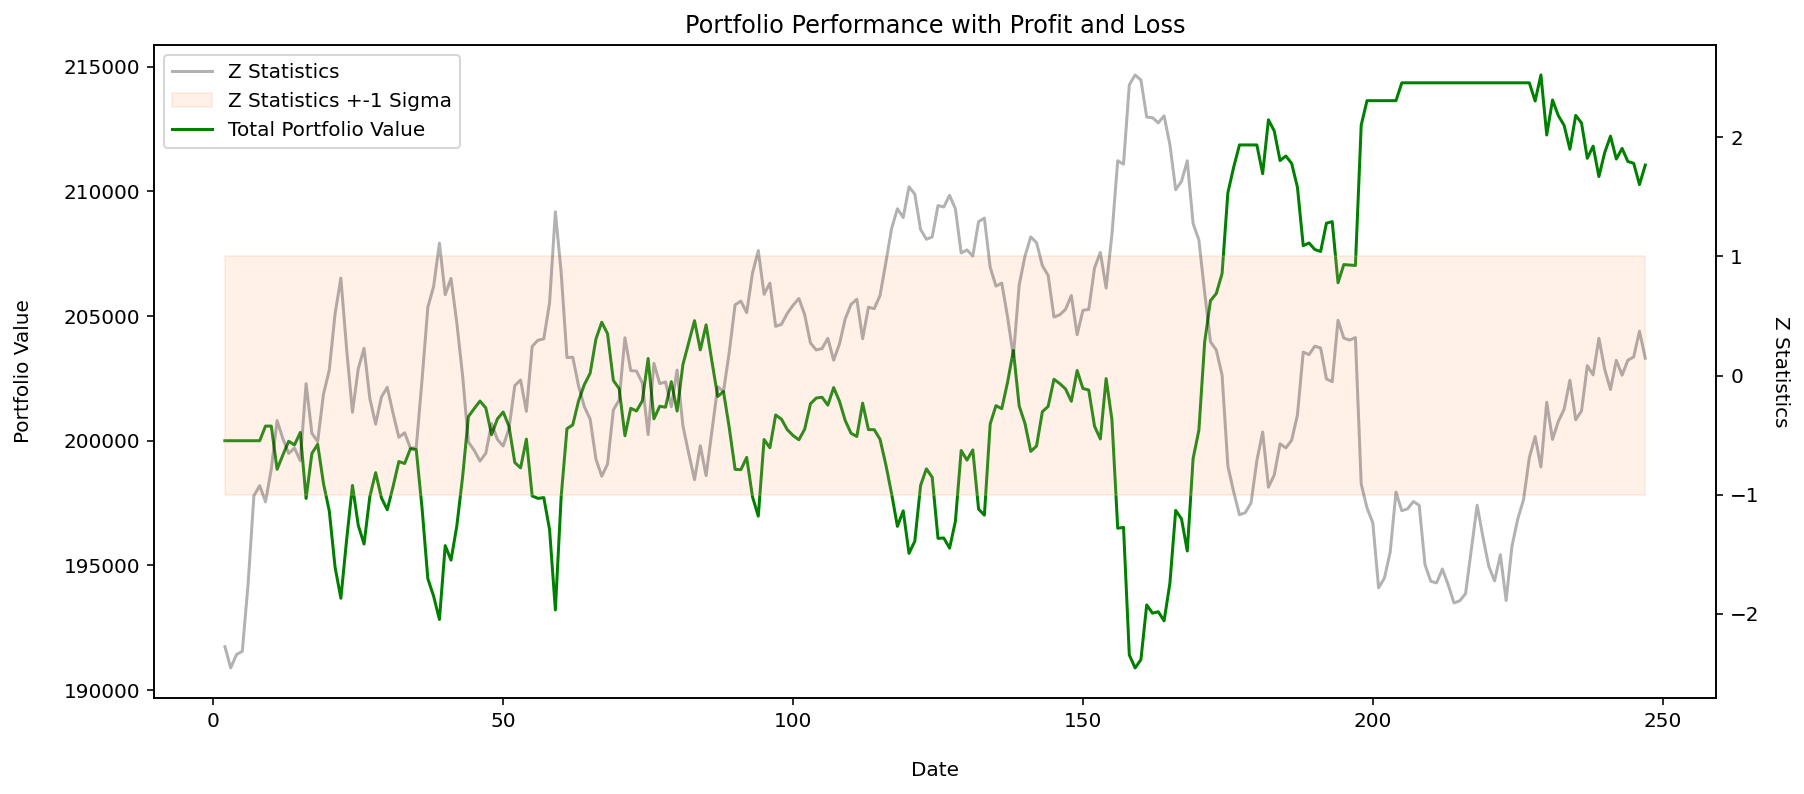

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [46]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

211055.8005119999

In [47]:
profit = final_portfolio - 2*initial_capital
profit

11055.8005119999

In [48]:
roi = (profit/(2*initial_capital))*100
roi

5.52790025599995

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [45]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 204.289%
